In this document, I training a model using Simple RNN, LSTM, GRU.

In [ ]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM,SimpleRNN, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed

set_seed(455)
np.random.seed(455)


In [ ]:
dataset = pd.read_csv(
    "Mastercard_stock_history.csv", index_col="Date", parse_dates=["Date"]
).drop(["Dividends", "Stock Splits"], axis=1)
print(dataset.head())

                Open      High       Low     Close     Volume
Date                                                         
2006-05-25  3.748967  4.283869  3.739664  4.279217  395343000
2006-05-26  4.307126  4.348058  4.103398  4.179680  103044000
2006-05-30  4.183400  4.184330  3.986184  4.093164   49898000
2006-05-31  4.125723  4.219679  4.125723  4.180608   30002000
2006-06-01  4.179678  4.474572  4.176887  4.419686   62344000


In [ ]:
tstart=2016
tend=2020
def train_test_split(dataset, tstart, tend):
    train = dataset.loc[f"{tstart}":f"{tend}", "High"].values
    test = dataset.loc[f"{tend+1}":, "High"].values
    return train, test
training_set, test_set = train_test_split(dataset, tstart, tend)


In [ ]:
#standarizing the datasets
sc = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)


In [ ]:
#split_sequence function uses a training dataset and converts it into inputs (X_train) and outputs (y_train).
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


n_steps = 60
features = 1
# split into samples
X_train, y_train = split_sequence(training_set_scaled, n_steps)
# Reshaping X_train for model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],features)


In [ ]:

# The LSTM architecture
model_lstm = Sequential()
model_lstm.add(LSTM(units=125, activation="tanh", input_shape=(n_steps, features)))
model_lstm.add(Dense(units=1))
# Compiling the model
model_lstm.compile(optimizer="RMSprop", loss="mse")

model_lstm.summary()
Model: "sequential"
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 125)               63500     
                                                                 
 dense (Dense)               (None, 1)                 126       
                                                                 
Total params: 63,626
Trainable params: 63,626
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
38/38 [==============================] - 6s 79ms/step - loss: 0.0142
Epoch 2/50
38/38 [==============================] - 3s 78ms/step - loss: 0.0027
Epoch 3/50
38/38 [==============================] - 3s 79ms/step - loss: 0.0020
Epoch 4/50
38/38 [==============================] - 3s 79ms/step - loss: 0.0019
Epoch 5/50
38/38 [==============================] - 3s 78ms/step - loss: 0.0014
Epoch 6/50
38/38 [==============================

In [ ]:
dataset_total = dataset.loc[:,"High"]
inputs = dataset_total[len(dataset_total) - len(test_set) - n_steps :].values
inputs = inputs.reshape(-1, 1)
#scaling
inputs = sc.transform(inputs)

# Split into samples
X_test, y_test = split_sequence(inputs, n_steps)
# reshape
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)
#prediction
predicted_stock_price = model_lstm.predict(X_test)
#inverse transform the values
predicted_stock_price = sc.inverse_transform(predicted_stock_price)


7/7 [==============================] - 1s 34ms/step


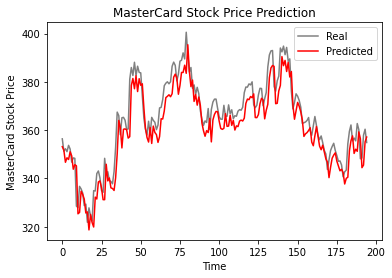

In [ ]:
def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("MasterCard Stock Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("MasterCard Stock Price")
    plt.legend()
    plt.show()


def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))
plot_predictions(test_set,predicted_stock_price)


## GRU Model

In [ ]:
model_gru = Sequential()
model_gru.add(GRU(units=125, activation="tanh", input_shape=(n_steps, features)))
model_gru.add(Dense(units=1))
# Compiling the RNN
model_gru.compile(optimizer="RMSprop", loss="mse")

model_gru.summary()
model_gru.fit(X_train, y_train, epochs=50, batch_size=32)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 125)               48000     
                                                                 
 dense_1 (Dense)             (None, 1)                 126       
                                                                 
Total params: 48,126
Trainable params: 48,126
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
38/38 [==============================] - 5s 60ms/step - loss: 0.0192
Epoch 2/50
38/38 [==============================] - 2s 59ms/step - loss: 0.0021
Epoch 3/50
38/38 [==============================] - 2s 60ms/step - loss: 0.0016
Epoch 4/50
38/38 [==============================] - 2s 58ms/step - loss: 0.0013
Epoch 5/50
38/38 [==============================] - 2s 59ms/step - loss: 9.1869e-04
Epoch 6/50
38/38 [========================

7/7 [==============================] - 1s 17ms/step


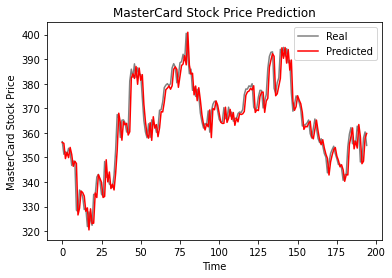

In [ ]:
GRU_predicted_stock_price = model_gru.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)
plot_predictions(test_set, GRU_predicted_stock_price)

## Simple model

In [ ]:
model_simple = Sequential()
model_simple.add(SimpleRNN(units=125, activation="tanh", input_shape=(n_steps, features)))
model_simple.add(Dense(units=1))
# Compiling the RNN
model_simple.compile(optimizer="RMSprop", loss="mse")

model_simple.summary()
model_simple.fit(X_train, y_train, epochs=50, batch_size=32)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 125)               15875     
                                                                 
 dense_2 (Dense)             (None, 1)                 126       
                                                                 
Total params: 16,001
Trainable params: 16,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
38/38 [==============================] - 2s 19ms/step - loss: 0.0324
Epoch 2/50
38/38 [==============================] - 1s 21ms/step - loss: 0.0062
Epoch 3/50
38/38 [==============================] - 1s 19ms/step - loss: 0.0033
Epoch 4/50
38/38 [==============================] - 1s 37ms/step - loss: 0.0021
Epoch 5/50
38/38 [==============================] - 1s 19ms/step - loss: 0.0307
Epoch 6/50
38/38 [============================

7/7 [==============================] - 0s 8ms/step


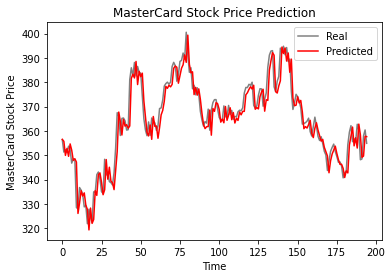

In [ ]:
simple_predicted_stock_price = model_simple.predict(X_test)
simple_predicted_stock_price = sc.inverse_transform(simple_predicted_stock_price)
plot_predictions(test_set, simple_predicted_stock_price)